In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Mestrado/ML/topicos_avançados/finetuned_model')

In [2]:
%%capture
!pip install datasets
!pip install tokenizers
!pip install torchmetrics
!pip install transformers
!pip install peft
!pip install evaluate


In [15]:
import torch
import numpy as np
import matplotlib . pyplot as plt
import csv
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    BertForSequenceClassification,
    DistilBertForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TrainerCallback)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25473
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 6369
    })
})


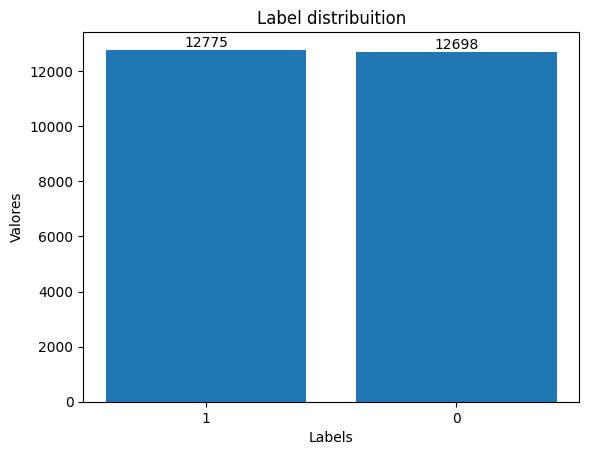

In [4]:
from typing_extensions import final
def read_and_label_csv(name, label):
    data = []
    with open(name, 'r', encoding='utf-8') as arquivo_csv:
        # Cria um leitor CSV
        leitor_csv = csv.reader(arquivo_csv)

        # Itera sobre as linhas do arquivo CSV e as armazena na lista
        for linha in leitor_csv:
            if len(linha)==0:
                continue
            else:
                 data.append(','.join(linha))
    return pd.DataFrame({"text":data,"label":label})

train_data_path ='/content/drive/MyDrive/Mestrado/ML/topicos_avançados/finetuned_model/data/train_data.csv'
val_data_path = '/content/drive/MyDrive/Mestrado/ML/topicos_avançados/finetuned_model/data/validation_data.csv'

train_data = Dataset.from_csv(train_data_path)
val_data = Dataset.from_csv(val_data_path)

test = {"train": train_data , "val": val_data}
final_data = DatasetDict(test)

print(final_data)

def plot_occurencies(data):
    contagem_valores = data['label'].value_counts()
    # Criação do histograma
    plt.bar(contagem_valores.index.astype(str), contagem_valores)

    # Adiciona o número total de ocorrências em cada barra
    for indice, valor in enumerate(contagem_valores):
        plt.text(indice, valor, str(valor), ha='center', va='bottom')
    plt.xlabel('Labels')
    plt.ylabel('Valores')
    plt.title("Label distribuition")

plot_occurencies(pd.read_csv(train_data_path))

In [25]:
model_checkpoint = 'distilbert-base-uncased'
# base model = 'distilbert-base-uncased'

# define label maps
id2label = {0: "Non  clickbait", 1: "Clickbait"}
label2id = {"Non  clickbait":0, "Clickbait":1}

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id).to(device)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.2.attention.output.dense.weight', 'encoder.layer.3.output.dense.weight', 'encoder.layer.6.output.dense.bias', 'encoder.layer.5.attention.output.LayerNorm.weight', 'encoder.layer.5.attention.self.value.bias', 'encoder.layer.3.output.LayerNorm.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.bias', 'encoder.layer.3.output.dense.bias', 'encoder.layer.9.attention.output.dense.bias', 'encoder.layer.10.attention.self.query.bias', 'encoder.layer.11.attention.output.LayerNorm.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.9.attention.self.query.weight', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.2.intermediate.dense.bias', 'classifier.bias', 'encoder.layer.1.attenti

In [8]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))


def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
       text,
        return_tensors="np",
        truncation=True,
        max_length=200
    )

    return tokenized_inputs
tokenized_dataset = final_data.map(tokenize_function, batched=True)

print(tokenized_dataset)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25473 [00:00<?, ? examples/s]

Map:   0%|          | 0/6369 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25473
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6369
    })
})


In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}


In [29]:

text_list = ["Which 2016 World Tour Should You See Based On Your Birth Month",
             "Canada pursues new nuclear research reactor to produce medical isotopes",
             "6 Untrue Facts About Mental Health You Probably Believe",
             "21 Call Center Horror Stories That'll Give You Nightmares",
             "Cuban talk show accuses U.S. diplomat of helping anti-government groups"]


peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=5,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ["query","key","value"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_peft_model(model, peft_config,).to(device)
print(model)
model.print_trainable_parameters()


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): PeftModelForSequenceClassification(
      (base_model): LoraModel(
        (model): BertForSequenceClassification(
          (bert): BertModel(
            (embeddings): BertEmbeddings(
              (word_embeddings): Embedding(30522, 768, padding_idx=0)
              (position_embeddings): Embedding(512, 768)
              (token_type_embeddings): Embedding(2, 768)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (encoder): BertEncoder(
              (layer): ModuleList(
                (0-11): 12 x BertLayer(
                  (attention): BertAttention(
                    (self): BertSelfAttention(
                      (query): lora.Linear(
                        (base_layer): Linear(in_features=768, out_features=768, bias=True)
                        (lora_dropout): ModuleDict(
             

In [28]:

class SaveModelCallback(TrainerCallback):
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        model.save_pretrained("/content/drive/MyDrive/Mestrado/ML/topicos_avançados/finetuned_model/"+ model_checkpoint + "-lora-clikbait_/" + f"model_epoch_{state.epoch}")



In [30]:
# hyperparameters
lr = 1e-3
batch_size = 24
num_epochs = 10

# define training arguments
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/Mestrado/ML/topicos_avançados/finetuned_model/"+ model_checkpoint + "-lora-clikbait",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
)

# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# Add the callback to the Trainer
# Create an instance of the callback class and add it to the Trainer
save_model_callback = SaveModelCallback()
trainer.add_callback(save_model_callback)


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.291900,0.257546,{'accuracy': 0.9205526770293609}
2,0.280700,0.253117,{'accuracy': 0.916156382477626}
3,0.374700,0.750958,{'accuracy': 0.4900298319987439}
4,0.717300,0.694084,{'accuracy': 0.5098131574815513}
5,0.706200,0.705447,{'accuracy': 0.5098131574815513}
6,0.700000,0.724989,{'accuracy': 0.5098131574815513}
7,0.695500,0.733327,{'accuracy': 0.5098131574815513}


Trainer is attempting to log a value of "{'accuracy': 0.9205526770293609}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.916156382477626}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.4900298319987439}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.5098131574815513}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.5098131574815513}" of

KeyboardInterrupt: ignored

In [24]:
print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to(device)

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

Trained model predictions:
--------------------------
Which 2016 World Tour Should You See Based On Your Birth Month - Non  clickbait
Canada pursues new nuclear research reactor to produce medical isotopes - Clickbait
6 Untrue Facts About Mental Health You Probably Believe - Non  clickbait
21 Call Center Horror Stories That'll Give You Nightmares - Non  clickbait
Cuban talk show accuses U.S. diplomat of helping anti-government groups - Clickbait
